# MIMIC Features

This notebook is used to find the most common features and their names in the MIMIC3 database. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
# for pretty printing table
pandas_table = pd.option_context('display.max_rows', None, 'display.max_columns', None)
# increased font size for thesis plots
plt.rcParams.update({'font.size': 15})

In [3]:
%%time
# load all rows in chartevents
df = pd.read_csv("../mimic/data_raw/CHARTEVENTS.csv.gz",
            usecols=["ITEMID", "CHARTTIME", "HADM_ID"],
            dtype={"ITEMID": int, "HADM_ID":int})

CPU times: user 3min 20s, sys: 6.73 s, total: 3min 26s
Wall time: 3min 26s


In [4]:
# total rows
df.shape

(330712483, 3)

In [5]:
df['HADM_ID'].unique().shape

(57272,)

In [6]:
%%time
# get count of each itemid
counts = df["ITEMID"].value_counts().sort_values(ascending=False)

CPU times: user 1.36 s, sys: 91.6 ms, total: 1.45 s
Wall time: 1.45 s


In [7]:
counts.shape

(6463,)

In [8]:
# load all itemids and names
variables = pd.read_csv("../mimic/data_raw/D_ITEMS.csv.gz",
                        dtype={"ITEMID": int})

# map between itemid and name
ITEMID_map = variables[["LABEL", 'ITEMID']].set_index('ITEMID').to_dict()['LABEL']

In [9]:
# Get name of each index
count_df = pd.DataFrame(counts)
count_df.columns = ['count']
count_df = count_df.reset_index()
count_df['Name'] = count_df.apply(lambda x: ITEMID_map[x['index']], axis=1)

Note - low index numbers are from carevue, higher are from metavision

In [10]:
with pandas_table:
    display(count_df[:300])

,index,count,Name
0,211,5180809,Heart Rate
1,742,3464326,calprevflg
2,646,3418917,SpO2
3,618,3386719,Respiratory Rate
4,212,3303151,Heart Rhythm
5,161,3236350,Ectopy Type
6,128,3216866,Code Status
7,550,3205052,Precautions
8,1125,2955851,Service Type
9,220045,2762225,Heart Rate


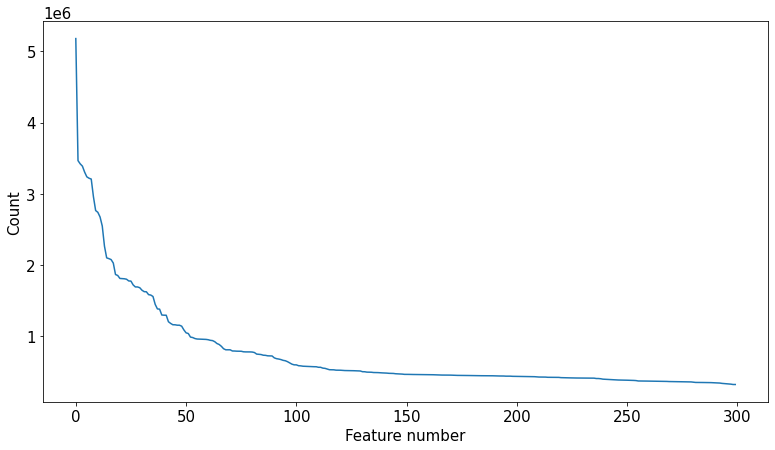

In [24]:
plt.figure(figsize=(13,7))
sns.lineplot(data=count_df[:300]['count'])
title = 'Number of Data Points for Most Common Items'
plt.ylabel('Count')
plt.xlabel('Feature number')
plt.savefig(os.path.join('figures', title))

## See count after pivot (e.g. daily occurrence)

In [12]:
%%time
df["CHARTTIME"] = pd.to_datetime(df["CHARTTIME"], format="%Y-%m-%d %H:%M:%S")

CPU times: user 1min 5s, sys: 3.07 s, total: 1min 8s
Wall time: 1min 8s


In [13]:
%%time
df["CHARTDATE"] = df["CHARTTIME"].dt.date
del df["CHARTTIME"]

CPU times: user 1min 7s, sys: 2.89 s, total: 1min 10s
Wall time: 1min 10s


In [14]:
# add column with dummy value
df['test'] = 1

In [15]:
%%time
pivot = pd.pivot_table(df, index=["HADM_ID", "CHARTDATE"], columns="ITEMID",
            aggfunc="first", values="test", fill_value=np.nan)

CPU times: user 5min 45s, sys: 2min 41s, total: 8min 27s
Wall time: 8min 44s


In [16]:
new_counts = pivot.count().sort_values(ascending=False)

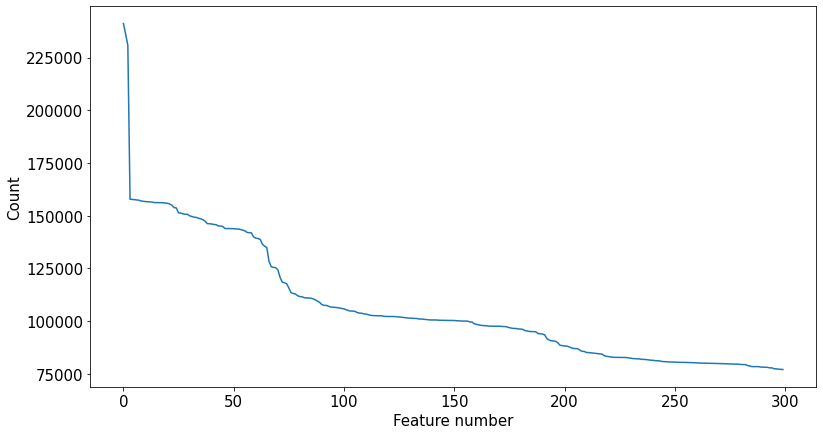

In [23]:
plt.figure(figsize=(13,7))
sns.lineplot(data=new_counts.reset_index()[0][:300])
title = 'Number of Data Points (Once Per Day per Patient)'
plt.ylabel('Count')
plt.xlabel('Feature number')
plt.savefig(os.path.join('figures', title))

In [18]:
# Get name of each index
new_count_df = pd.DataFrame(new_counts)
new_count_df.columns = ['count']
new_count_df = new_count_df.reset_index()
new_count_df['Name'] = new_count_df.apply(lambda x: ITEMID_map[x['ITEMID']], axis=1)

In [19]:
with pandas_table:
    display(new_count_df[:300])

,ITEMID,count,Name
0,211,241092,Heart Rate
1,31,236115,Activity
2,80,230807,Bowel Sounds
3,212,157814,Heart Rhythm
4,742,157746,calprevflg
5,161,157608,Ectopy Type
6,618,157423,Respiratory Rate
7,646,157363,SpO2
8,432,157020,Level of Conscious
9,617,156824,Respiratory Pattern


## See how many days have no missing data

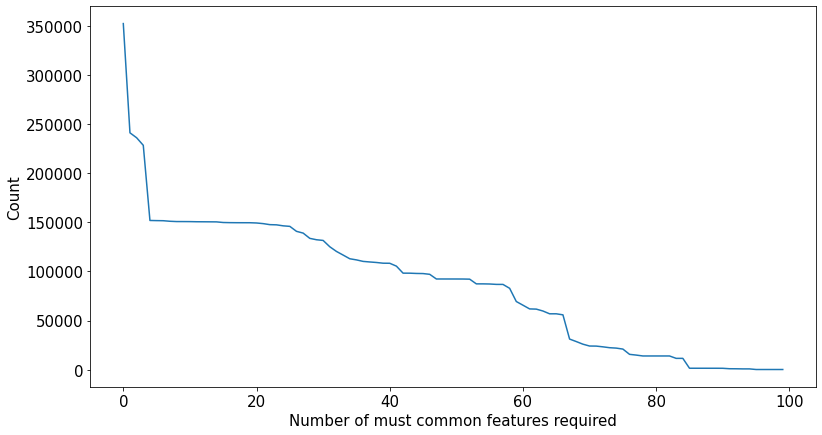

In [36]:
x = range(100)
y = [len(pivot[new_counts.index[:x]].dropna()) for x in x]
plt.figure(figsize=(13,7))
sns.lineplot(x=x, y=y)
title = 'Days of Full Data'
plt.ylabel('Count')
# plt.xticks(x)
plt.xlabel('Number of must common features required')
plt.savefig(os.path.join('figures', title))

In [35]:
list(zip(x,y))

[(0, 352325),
 (1, 241092),
 (2, 236076),
 (3, 228383),
 (4, 151857),
 (5, 151707),
 (6, 151602),
 (7, 151042),
 (8, 150744),
 (9, 150729),
 (10, 150691),
 (11, 150560),
 (12, 150516),
 (13, 150471),
 (14, 150414),
 (15, 149785),
 (16, 149641),
 (17, 149580),
 (18, 149557),
 (19, 149548),
 (20, 149294),
 (21, 148645),
 (22, 147604),
 (23, 147404),
 (24, 146394),
 (25, 145853),
 (26, 140787),
 (27, 139000),
 (28, 133636),
 (29, 132236),
 (30, 131525),
 (31, 125083),
 (32, 120329),
 (33, 116632),
 (34, 112870),
 (35, 111723),
 (36, 110187),
 (37, 109602),
 (38, 109080),
 (39, 108349),
 (40, 108276),
 (41, 105355),
 (42, 98216),
 (43, 98188),
 (44, 97911),
 (45, 97795),
 (46, 97036),
 (47, 92275),
 (48, 92271),
 (49, 92267),
 (50, 92262),
 (51, 92236),
 (52, 92094),
 (53, 87305),
 (54, 87304),
 (55, 87171),
 (56, 86776),
 (57, 86740),
 (58, 82774),
 (59, 69327),
 (60, 65580),
 (61, 61803),
 (62, 61596),
 (63, 59660),
 (64, 56826),
 (65, 56826),
 (66, 55773),
 (67, 31103),
 (68, 28572),
 (